<a href="https://colab.research.google.com/github/simecek/dspracticum2024/blob/main/lesson05/Tokenization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tokenization

Adapted from [Andrej Karpathy's materials](https://colab.research.google.com/drive/1y0KnCFZvGVf_odSfcNAws6kcDD7HsI0L?usp=sharing)

##  Overview

Tokenization is essential for LLMs, breaking text into smaller units (tokens) that a model can process.

### Unicode and UTF-8
Text is represented in Unicode, and UTF-8 is a common encoding to convert Unicode to bytes.

* `ord()`: Converts a character to its Unicode code point.
* `encode()`: Converts a string to bytes.
* `decode()`: Converts bytes back to a string.

Example:

In [ ]:
# Convert string to Unicode code points
[ord(x) for x in "안녕하세요 👋 (hello)"]

[50504,
 45397,
 54616,
 49464,
 50836,
 32,
 128075,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 41]

In [ ]:
list("안녕하세요 👋 (hello)".encode("utf-8"))

[236,
 149,
 136,
 235,
 133,
 149,
 237,
 149,
 152,
 236,
 132,
 184,
 236,
 154,
 148,
 32,
 240,
 159,
 145,
 139,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 41]

In [ ]:
"안녕하세요 👋 (hello)".encode("utf-8").decode("utf-8")

'안녕하세요 👋 (hello)'

Good tokenization web app: [https://tiktokenizer.vercel.app](https://tiktokenizer.vercel.app)

Example string:

```
Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

127 + 677 = 804
1275 + 6773 = 8041

Egg.
I have an Egg.
egg.
EGG.

만나서 반가워요. 저는 OpenAI에서 개발한 대규모 언어 모델인 ChatGPT입니다. 궁금한 것이 있으시면 무엇이든 물어보세요.

for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
```

---

Much glory awaits someone who can delete the need for tokenization. But meanwhile, let's learn about it.

## Byte Pair Encoding (BPE)

BPE is a compression-like algorithm to combine frequently occurring byte pairs into tokens, reducing the total number of tokens needed. The goal is to minimize token length while maximizing vocabulary efficiency.

**Example BPE process:**

Start with the text encoded as bytes.
Merge the most frequent byte pairs iteratively.
The resulting tokens are stored in a vocabulary.
Simplified code example:

In [2]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge(ids, pair, new_token):
    result = []
    i = 0
    while i < len(ids):
        if i < len(ids) - 1 and (ids[i], ids[i+1]) == pair:
            result.append(new_token)
            i += 2
        else:
            result.append(ids[i])
            i += 1
    return result

ids = list("aaabdaaabac".encode("utf-8"))
ids

[97, 97, 97, 98, 100, 97, 97, 97, 98, 97, 99]

In [4]:
get_stats(ids)

{(97, 97): 4,
 (97, 98): 2,
 (98, 100): 1,
 (100, 97): 1,
 (98, 97): 1,
 (97, 99): 1}

In [12]:
max([(value, pair) for pair, value in get_stats(ids).items()])

(4, (97, 97))

In [16]:
new_ids = merge(ids, (97, 97), -1)
new_ids

[-1, 97, 98, 100, -1, 97, 98, 97, 99]

Note, the Tokenizer is a completely separate, independent module from the LLM. It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algorithm. It then translates back and forth between raw text and sequences of tokens. The LLM later only ever sees the tokens and never directly deals with any text.

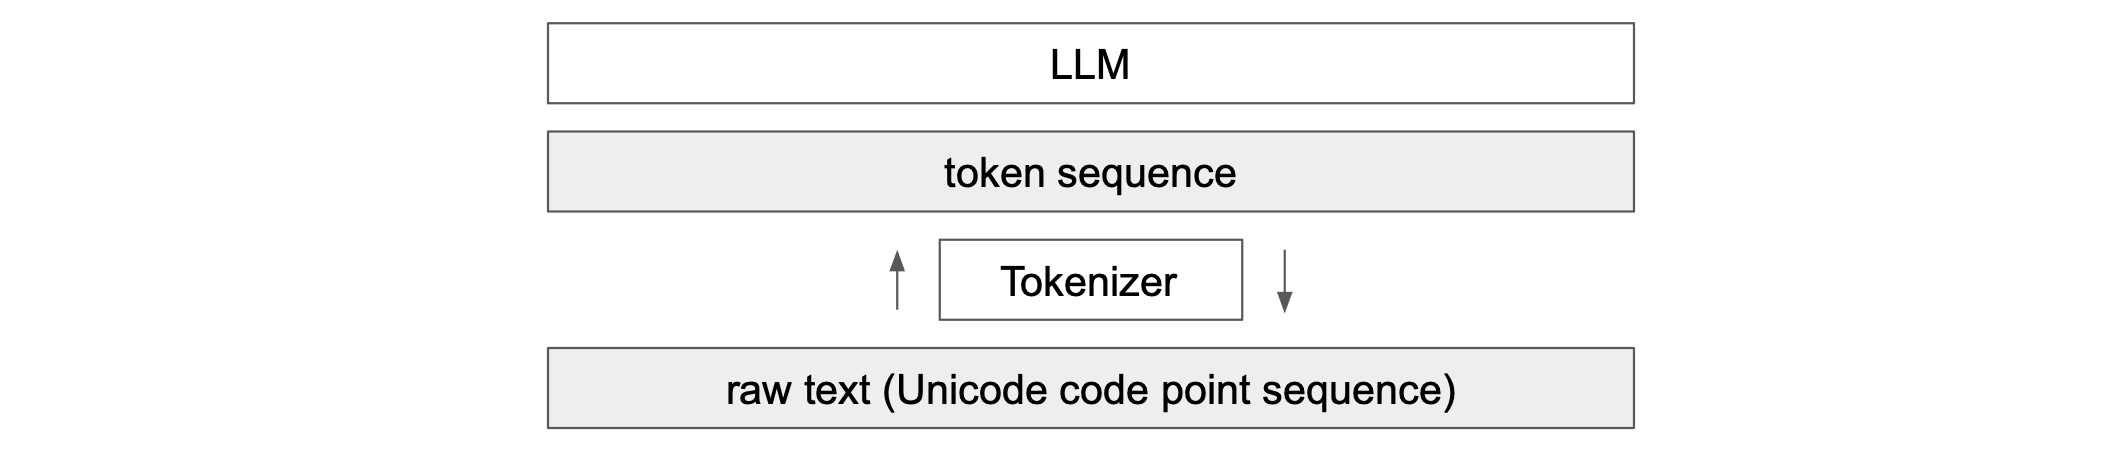

### decoding

Given a sequence of integers in the range [0, vocab_size], what is the text?


### Forced splits using regex patterns (GPT series)


In [17]:
import regex as re
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

print(re.findall(gpt2pat, "Hello've world123 how's are you!!!?"))

['Hello', "'ve", ' world', '123', ' how', "'s", ' are', ' you', '!!!?']


## Tiktoken

Tiktoken is used by OpenAI models like GPT-2 and GPT-4o. It first encodes the text into UTF-8 bytes, then applies BPE to these bytes.

Example:

In [18]:
!pip install -qq tiktoken # added for colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.3 MB/s eta 0:00:00


In [19]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")
tokens = enc.encode("안녕하세요 👋 (hello in Korean!)")
print(tokens)  # Encoded tokens
print(enc.decode(tokens))  # Decoded text

[31495, 230, 75265, 243, 92245, 62904, 233, 320, 15339, 304, 16526, 16715]
안녕하세요 👋 (hello in Korean!)


### sentencepiece

Commonly used because (unlike tiktoken) it can efficiently both train and inference BPE tokenizers. It is used in both Llama and Mistral series.

[sentencepiece on Github link](https://github.com/google/sentencepiece).

**The big difference**: sentencepiece runs BPE on the Unicode code points directly! It then has an option `character_coverage` for what to do with very very rare codepoints that appear very few times, and it either maps them onto an UNK token, or if `byte_fallback` is turned on, it encodes them with utf-8 and then encodes the raw bytes instead.

TLDR:

- tiktoken encodes to utf-8 and then BPEs bytes
- sentencepiece BPEs the code points and optionally falls back to utf-8 bytes for rare code points (rarity is determined by character_coverage hyperparameter), which then get translated to byte tokens.

(Personally I think the tiktoken way is a lot cleaner...)

In [20]:
import sentencepiece as spm

In [ ]:
# write a toy.txt file with some random text
with open("toy.txt", "w", encoding="utf-8") as f:
  f.write("SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.")

Docs for sentencepiece options:

- [markdown](https://github.com/google/sentencepiece/blob/master/doc/options.md)
- [protobuf](https://github.com/google/sentencepiece/blob/master/src/sentencepiece_model.proto#L193)

In [ ]:
# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="toy.txt",
  input_format="text",
  # output spec
  model_prefix="tok400", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=400,
  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995,
  byte_fallback=True,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1,
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)


In [ ]:
sp = spm.SentencePieceProcessor()
sp.load('tok400.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
vocab

[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['<0x00>', 3],
 ['<0x01>', 4],
 ['<0x02>', 5],
 ['<0x03>', 6],
 ['<0x04>', 7],
 ['<0x05>', 8],
 ['<0x06>', 9],
 ['<0x07>', 10],
 ['<0x08>', 11],
 ['<0x09>', 12],
 ['<0x0A>', 13],
 ['<0x0B>', 14],
 ['<0x0C>', 15],
 ['<0x0D>', 16],
 ['<0x0E>', 17],
 ['<0x0F>', 18],
 ['<0x10>', 19],
 ['<0x11>', 20],
 ['<0x12>', 21],
 ['<0x13>', 22],
 ['<0x14>', 23],
 ['<0x15>', 24],
 ['<0x16>', 25],
 ['<0x17>', 26],
 ['<0x18>', 27],
 ['<0x19>', 28],
 ['<0x1A>', 29],
 ['<0x1B>', 30],
 ['<0x1C>', 31],
 ['<0x1D>', 32],
 ['<0x1E>', 33],
 ['<0x1F>', 34],
 ['<0x20>', 35],
 ['<0x21>', 36],
 ['<0x22>', 37],
 ['<0x23>', 38],
 ['<0x24>', 39],
 ['<0x25>', 40],
 ['<0x26>', 41],
 ['<0x27>', 42],
 ['<0x28>', 43],
 ['<0x29>', 44],
 ['<0x2A>', 45],
 ['<0x2B>', 46],
 ['<0x2C>', 47],
 ['<0x2D>', 48],
 ['<0x2E>', 49],
 ['<0x2F>', 50],
 ['<0x30>', 51],
 ['<0x31>', 52],
 ['<0x32>', 53],
 ['<0x33>', 54],
 ['<0x34>', 55],
 ['<0x35>', 56],
 ['<0x36>', 57],
 ['<0x37>', 58],
 ['<0x38>', 5

In [ ]:
ids = sp.encode("hello 안녕하세요")
print(ids)

[362, 378, 361, 372, 358, 362, 239, 152, 139, 238, 136, 152, 240, 152, 155, 239, 135, 187, 239, 157, 151]


In [ ]:
print([sp.id_to_piece(idx) for idx in ids])

['▁', 'h', 'e', 'l', 'lo', '▁', '<0xEC>', '<0x95>', '<0x88>', '<0xEB>', '<0x85>', '<0x95>', '<0xED>', '<0x95>', '<0x98>', '<0xEC>', '<0x84>', '<0xB8>', '<0xEC>', '<0x9A>', '<0x94>']


**Llama 2 tokenizer proto**
If you'd like to export the raw protocol buffer for the `tokenizer.model` released by meta, this is a [helpful issue](https://github.com/google/sentencepiece/issues/121). And this is the result:

```
normalizer_spec {
  name: "identity"
  precompiled_charsmap: ""
  add_dummy_prefix: true
  remove_extra_whitespaces: false
  normalization_rule_tsv: ""
}

trainer_spec {
  input: "/large_experiments/theorem/datasets/MERGED/all.test1.merged"
  model_prefix: "spm_model_32k_200M_charcov099995_allowWSO__v2"
  model_type: BPE
  vocab_size: 32000
  self_test_sample_size: 0
  input_format: "text"
  character_coverage: 0.99995
  input_sentence_size: 200000000
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  num_threads: 80
  num_sub_iterations: 2
  max_sentence_length: 4192
  shuffle_input_sentence: true
  max_sentencepiece_length: 16
  split_by_unicode_script: true
  split_by_whitespace: true
  split_by_number: true
  treat_whitespace_as_suffix: false
  split_digits: true
  allow_whitespace_only_pieces: true
  vocabulary_output_piece_score: true
  hard_vocab_limit: true
  use_all_vocab: false
  byte_fallback: true
  required_chars: ""
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_surface: " \342\201\207 "
  unk_piece: "<unk>"
  bos_piece: "<s>"
  eos_piece: "</s>"
  pad_piece: "<pad>"
  train_extremely_large_corpus: false
  enable_differential_privacy: false
  differential_privacy_noise_level: 0.0
  differential_privacy_clipping_threshold: 0
}
```